# Development notebook for processing sexual dimorphism data

In [1]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

#note 25.03.24 - holoviews import causes bug where no plots are displayed...
#import holoviews as hv
#from holoviews.operation.datashader import datashade
#from holoviews import opts, dim
#from holoviews.operation.datashader import rasterize
#hv.extension('matplotlib')
#from colorcet import fire

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data_loading)
3. [Filtering](#filtering)
    1. [Cell Exclusion](#cell_exclusion_l1)
    2. [Male vs. Female Gene Expression](#avg_bool_mf_df_sorted_l2)
    3. [Gene Exclusion](#gene_exclusion_l1)
4. [Feature Selection](feat_selection) 
    1. [CV analysis](#get_top_cv_genes)
5. [Preprocessing](#preprocessing) 
    1. [Log and Standerdize](#log_and_standerdize)
6. [Dimensionality Reduction](#dim_reduction)
    1. [PCA](#analyze_pca)
    2. [t-SNE](#tsne)
        1. [Computing Perplexity](#get_perplexity)
        2. [Visualization](#do_tsne)
        3. [Marker Gene Overlay](#tsne_marker)
7. [Clustering](#clustering)
    1. [DBSCAN](#dbscan)
        1. [Computing Epsilon](#get_epsilon)
        2. [Visualization](#do_dbscan)
8. [Sorting](#cluster_sort)
    1. [Inter Cluster Sorting](#inter_cluster_sort)
    2. [Intra Cluster Sorting](#intra_cluster_sort)
9. [Marker Genes](#markergenes)
    1. [Compute Markers](#compute_marker_genes)
    2. [Heatmap](marker_heatmap)

## Introduction <a name="introduction"></a>

Analysis notebook for processing sexual dimorphism data. Each processing step calls a function from dimorph_processing.py

## Data Loading <a name="data_loading"></a>

Intialize metadata (meta_data_df), gene expression data (df), boolean gene expression data (df_bool), and status tracking (status_df)

In [2]:
meta_data_df, df_orig, df_bool, status_df = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
df_orig.shape

(27933, 79613)

In [4]:
df_orig.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,0,2,0,0,1,3,2,0,...,1,0,1,0,2,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,2,2,0,1,0,...,0,0,0,0,2,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,1,0,0,0,2,1,1,0,...,1,0,2,0,1,0,1,0,0,0


In [5]:
meta_data_df.shape

(27, 79613)

In [6]:
meta_data_df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
Serial_Number,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,...,,,,,,,,,,


In [7]:
status_df

,completion_status
cell_exclusion (l1),NaN
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


## Filtering <a name="filtering"></a>

### Cell Exclusion <a name="cell_exclusion_l1"></a>

Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [8]:
df, df_bool, meta_data_df, status_df = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      meta_data_df = meta_data_df,
                                                      df_bool = df_bool,
                                                      df = df_orig,
                                                      status_df = status_df)


Total cells reduced from 79613 to 43492


In [9]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [10]:
df.shape #rerun

(27933, 43492)

In [11]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


Sanity Check of known specific sex genes

In [12]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

True
True
True
True
True
True


### Male vs. Female Gene Expression <a name="avg_bool_mf_df_sorted_l2"></a>

num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


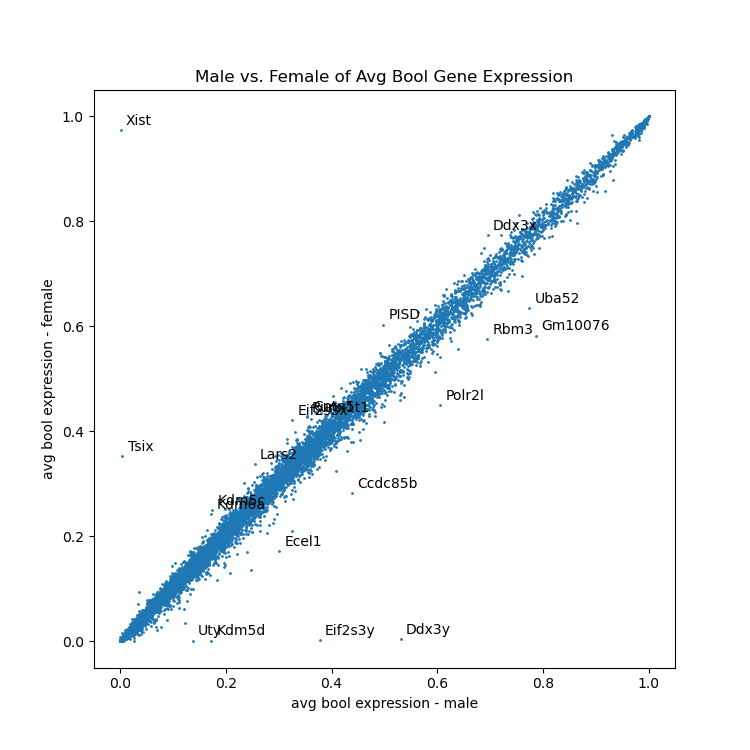

In [13]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = df_bool,
                                                              meta_data_df=meta_data_df,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### Gene Exclusion <a name="gene_exclusion_l1"></a> 

Keep only genes expressed in >10 cells, <50% of all cells

In [14]:
df, df_bool, meta_data_df, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=df_bool,
                                                     df = df,
                                                     meta_data_df = meta_data_df,
                                                     status_df = status_df)
df.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [15]:
meta_data_df.shape

(27, 43492)

In [16]:
df.shape

(17081, 43492)

In [17]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


#### Sanity Check of known specific sex genes

In [18]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

False
True
True
True
True
True


## Feature Selection <a name="feat_selection"></a> 

### CV Analysis <a name="get_top_cv_genes"></a> 

<IPython.core.display.Javascript object>


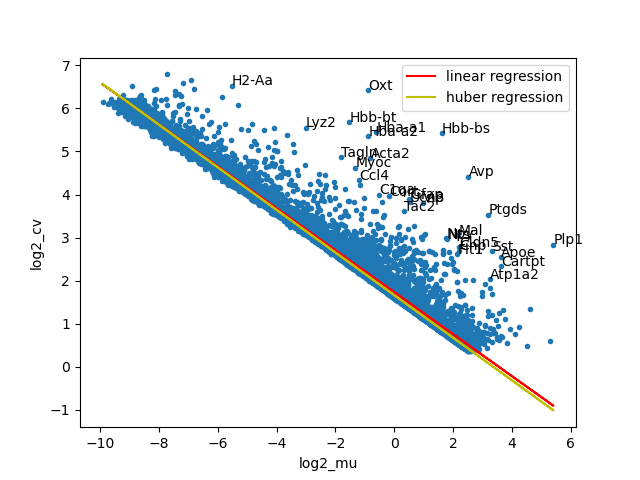

In [19]:
cv_df = dp.analyze_cv(df = df,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

In [20]:
cv_df.head()

,log2mu,log2cv,delta_cv
gene,,,
Hbb-bs,1.620289,5.429946,4.570352
Oxt,-0.879842,6.428204,4.330631
Avp,2.526425,4.414903,4.003995
Plp1,5.415903,2.831623,3.851485
Hba-a1,-0.615138,5.448019,3.481519


In [21]:
cv_df.shape

(17081, 3)

Use highest variation CV genes to get top genes

<IPython.core.display.Javascript object>


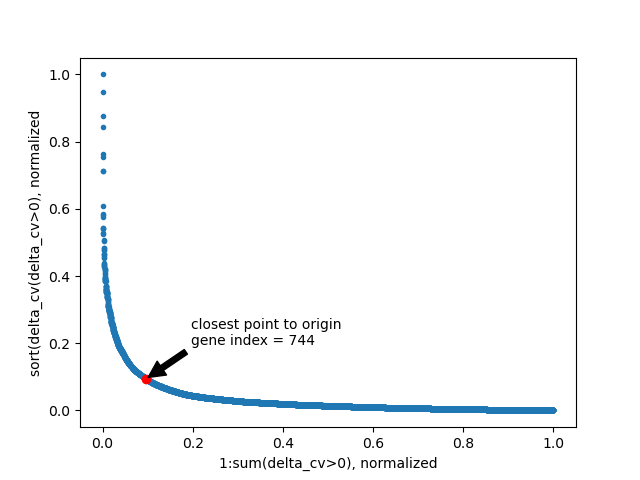

In [22]:
gene_index, df, status_df = dp.get_top_cv_genes(df = df, cv_df=cv_df, plot_flag=1, status_df=status_df)

In [23]:
df.shape

(744, 43492)

In [24]:
gene_index

744

In [25]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


utilize mean-variance relationship (PCA). Why this as opposed t mean-dropout relationship? see 'feature selection' section in :
https://www.nature.com/articles/s41467-019-13056-x

## Preprocessing <a name="preprocessing"></a> 

### Log and Standerdize <a name="#log_and_standerdize"></a> 

In [26]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plp1,0,0,2,0,0,0,1,0,0,0,...,1,0,0,1,0,71,0,0,0,1
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df.shape

(744, 43492)

In [28]:
log_std_arr,status_df = dp.log_and_standerdize_df(df,status_df)

column (gene) mean after standardization: 0.00
column (gene) sigma after standardization: 1.00


In [29]:
log_std_arr.shape

(43492, 744)

In [30]:
log_std_arr.shape

(43492, 744)

In [31]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


In [32]:
df_ls = pd.DataFrame(data = log_std_arr.T, index = df.index, columns=df.columns)

## Dimensionality Reduction <a name="dim_reduction"></a> 

### PCA <a name="analyze_pca"></a> 

Do PCA intially with num components = all genes, use normalized explained variance to select highest variation PCs and reduce gene expression to this dimension 

<IPython.core.display.Javascript object>


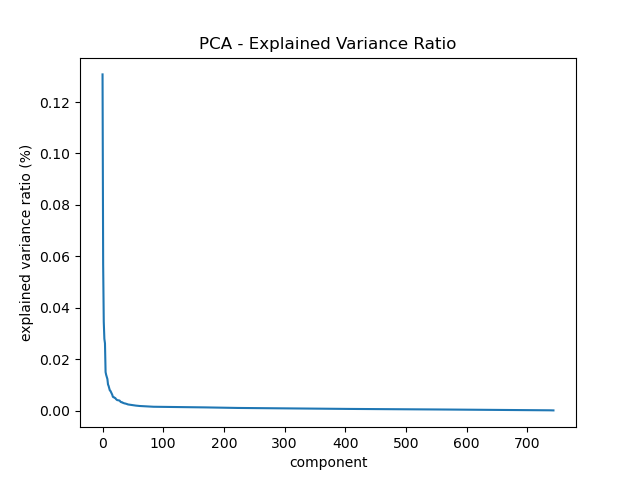

<IPython.core.display.Javascript object>


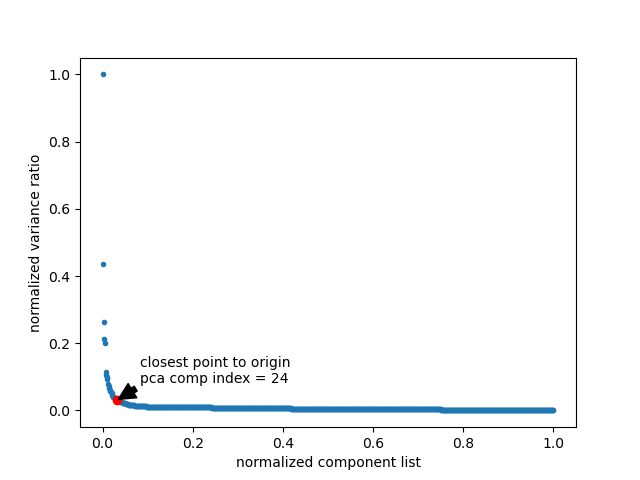

<IPython.core.display.Javascript object>


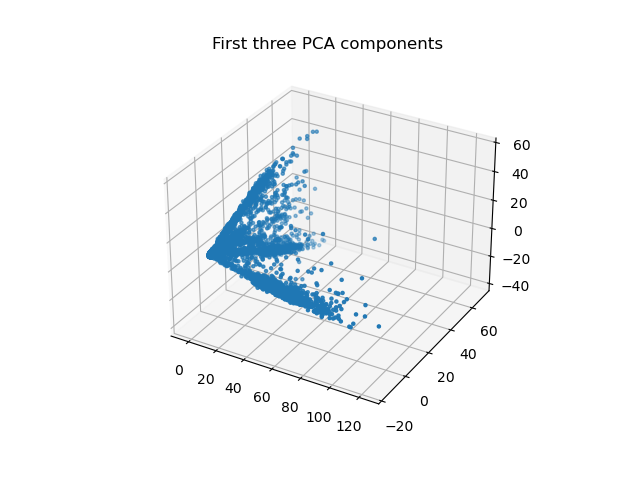

In [33]:
pca_index, arr_pca, status_df = dp.analyze_pca(arr = log_std_arr, #log_std_arr
                                               n_components=log_std_arr.shape[1], #log_std_arr.shape[1]
                                               optimize_n=True,
                                               plot_flag=1, 
                                               status_df=status_df)

In [34]:
arr_pca.shape

(43492, 24)

In [35]:
pca_index

24

In [36]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


In [37]:
'Apoe' in df.index

True

### t-SNE <a name="tsne"></a> 

#### Computing Perplexity <a name="get_perplexity"></a> 

Amit's method for determining perplexity param - 
1) compute pairwise distance matrix (n_cells x n_cells) from PCA reduced matrix.
2) sort columns by ascending values
3) compute angle from first point to last point of column values from index 1-500
4) use rotation matrix to rotate column values by this angle
5) take argmax for each rotated set of column values and store in list
6) take median of list created in step 5, this is perplexity value



<IPython.core.display.Javascript object>


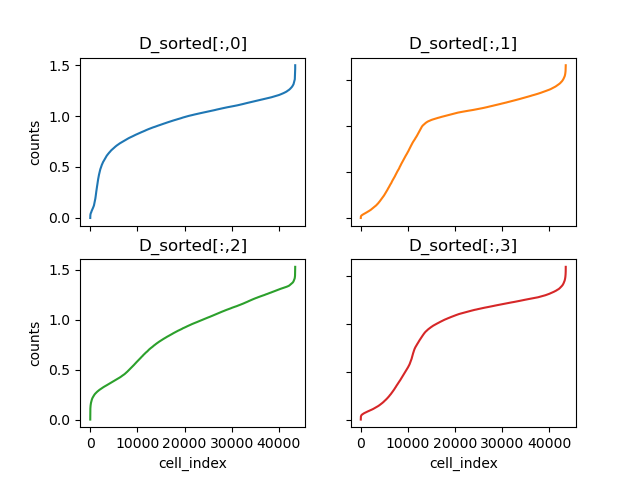

<IPython.core.display.Javascript object>


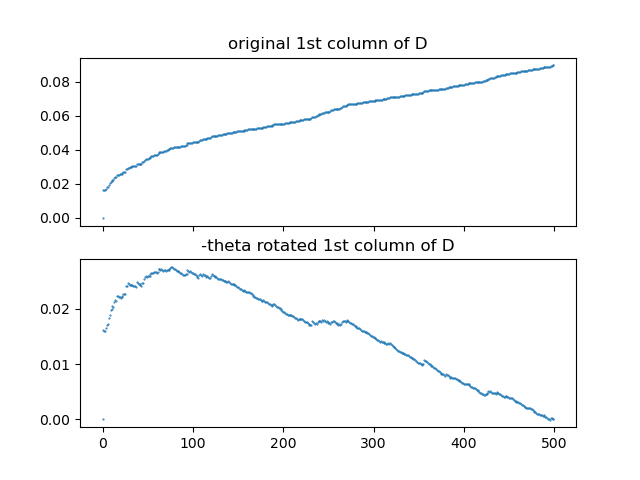

In [38]:
perplexity,status_df = dp.get_perplexity(pca_arr = arr_pca, cutoff=500, plot_flag=1, status_df = status_df)

In [39]:
perplexity

57.0

In [40]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


#### Visualize with t-SNE<a name="do_tsne"></a> 

In [41]:
arr_pca.shape

(43492, 24)

Do TSNE on pca reduced matrix using calculated perplexity. See https://www.nature.com/articles/s41467-019-13056-x for more details on parameter selection.

Note sklearn's learning rate is defined factor of 4 smaller than other implementations, see sklearn doc: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Create a t-SNE object

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 57.0


<IPython.core.display.Javascript object>


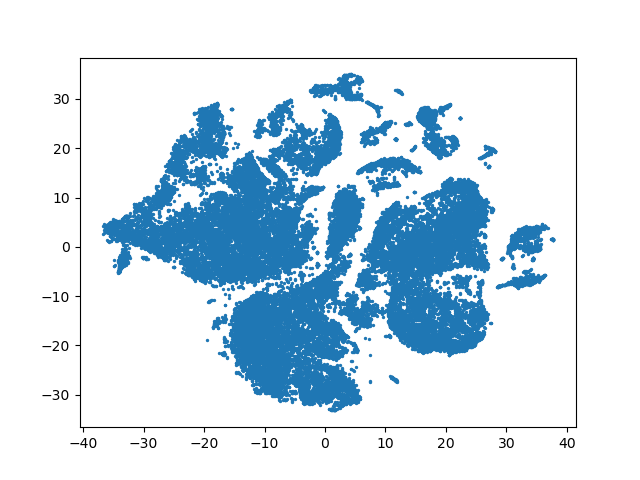

In [42]:
arr_tsne,status_df = dp.do_tsne(arr = arr_pca, 
                               n_components=2,
                               n_iter=1000,
                               learning_rate=50,
                               early_exaggeration=12,
                               init='pca', 
                               perplexity = perplexity,
                               status_df = status_df)

In [43]:
arr_tsne.shape

(43492, 2)

In [44]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,True
compute_eps,NaN
do_dbscan,NaN


#### Overlay tSNE with known marker genes <a name="tsne_marker"></a> 

As a sanity check, plot a positively expressed known marker gene on top of tSNE plot.
Known marker genes from: 
https://www.science.org/doi/full/10.1126/science.aaa1934)

In [45]:
tsne = TSNE(n_components=2,
            n_iter=1000,
            learning_rate=50,
           early_exaggeration=12,
           init='pca', 
           perplexity = perplexity)

# Apply t-SNE on the arr
X_tsne = tsne.fit_transform(arr_pca)

In [46]:
#Mpb, Gad1, Aldoc, Cldn5(good), Acta2 (good)

gene in df?  True
gene index:  [61]
num cells with positive expression of gene, Snca: 188


<IPython.core.display.Javascript object>


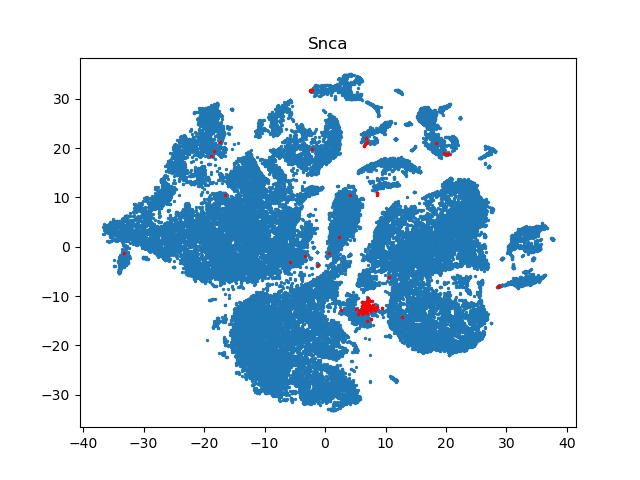

In [47]:
gene = 'Snca'
print('gene in df? ', gene in df.index)
print ('gene index: ', np.where(df.index == gene)[0])

#boolean array where True = gene postively expressed
x = df.iloc[np.where(df.index == gene)[0],:]>0
       
x_arr = x.to_numpy()
#use array of cell names to get cell index       
result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]
print (f'num cells with positive expression of gene, {gene}:', len(result))

#visualise tsne
ax, fig = plt.subplots()
plt.title(gene)
fig.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 2)
fig.scatter(X_tsne[result,0], X_tsne[result,1], s = 2, c = 'r')
plt.show()

In [48]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,True
compute_eps,NaN
do_dbscan,NaN


## Clustering <a name="clustering"></a>

### DBSCAN <a name="dbscan"></a>

#### Computing Epsilon <a name="get_epsilon"></a> 

In [49]:
epsilon, minpts, status_df = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne, status_df = status_df)

params for dbscan
minpts:  35
epsilon:  0.9426212663945247



Alternative method for finding epsilon- calculate avg distance between each point and its n_neighbors (equal to min_pts), plot, and select point of max curvature 

In [50]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(arr_tsne)
distances, indices = neighbors_fit.kneighbors(arr_tsne)

<IPython.core.display.Javascript object>


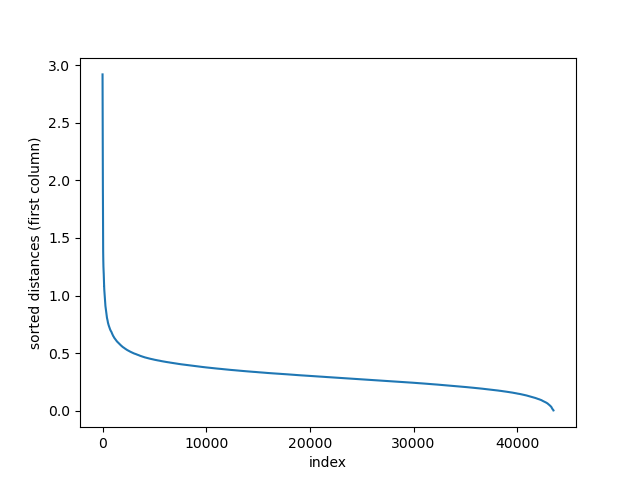

In [51]:
distances = np.flip(np.sort(distances, axis=0))
distances_c1 = distances[:,1]
fig,ax = plt.subplots()
plt.plot(distances_c1)
plt.xlabel('index')
plt.ylabel('sorted distances (first column)')
plt.show()

#### Visualize DBScan Clusters <a name="do_dbscan"></a> 

Use scikit-learn implementaton: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Uncomment code below to perform dbscan clustering on range of minpts values: 10,15,20,25,30,35, with epsiolon computed for each. corresponding epsilon values for each

In [52]:
arr_tsne.shape

(43492, 2)

In [53]:
#for m in range(10,40,5):
    #epsilon, minpts = dp.compute_eps(minpts = m, eps_prc=90, arr= arr_tsne, status_df = status_df)
    #labels,n_clusters, arr = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne, status_df = status_df)

Pick case where minpts = 35

params for dbscan
minpts:  35
epsilon:  0.9426212663945247

running dbscan with epsilon: 0.9426212663945247  and minpts: 35
Estimated number of clusters: 30
Estimated number of noise points: 848


<IPython.core.display.Javascript object>


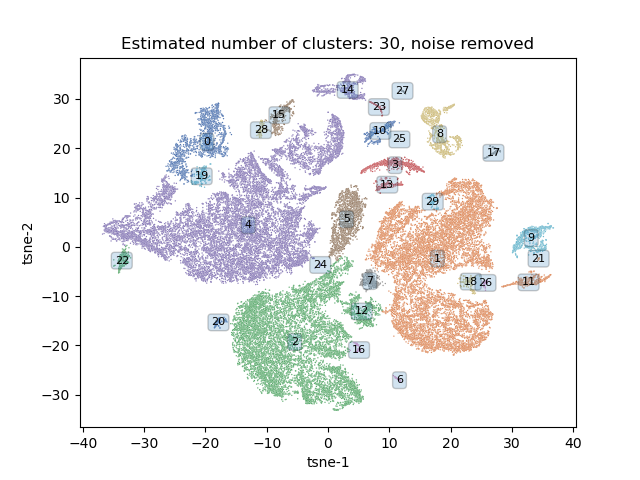

In [54]:
epsilon, minpts, status_df = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne, status_df = status_df)
labels, n_clusters_, arr_df, status_df = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne, status_df = status_df)

In [55]:
#numpy method to get cluster and pts per cluster
#c,p = np.unique(labels,return_counts=True)

View histogram showing number of pts per cluster

<IPython.core.display.Javascript object>


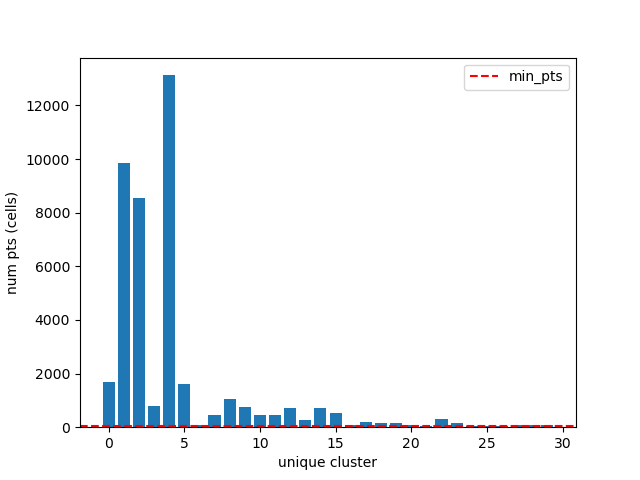

In [56]:
dp.histogram_pts_per_cluster(labels, minpts=minpts)

Reshuffle gene expression matrix, meta data using cluster labels

In [57]:
#df_pre_linkage, meta_data_df, unique_labels = dp.sort_by_cluster_label(df,meta_data_df,arr_df,labels)

In [58]:
#df_pre_linkage.head()

In [59]:
#meta_data_df

write df_pre_linkage and meta_data_df to file

In [60]:
len(np.arange(31))

31

In [61]:
#outfile_name = 'df_pre_linkage'
#df_pre_linkage.to_feather('/bigdata/isaac/'+outfile_name+'.feather')

#outfile_name = 'meta_data_df_pre_linkage'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')

#meta_data_df = pd.read_json('/bigdata/isaac/meta_data_df_pre_linkage.json')

In [64]:
#try with normalized gene expr as input!
#outfile_name = 'df_pre_linkage_ls'
#df_pre_linkage.to_feather('/bigdata/isaac/'+outfile_name+'.feather')
#outfile_name = 'meta_data_df_pre_linkage_ls'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')

#meta_data_df = pd.read_json('/bigdata/isaac/meta_data_df_pre_linkage.json')
df_pre_linkage_ls, meta_data_df, unique_labels = dp.sort_by_cluster_label(df_ls,meta_data_df,arr_df,labels)

## Sorting <a name="cluster_sort"></a>

### Inter Cluster sorting <a name="inter_cluster_sort"></a>

Inter cluster Order determined as follows:
1) compute mean per gene per cluster(n_genes x n_clusters)
2) PCA reduce genes to n_components (10)
3) Compute distance matrix on PCA reduced array using 'correlation' as distance metric
4) Compute linkage on distance matrix using 'ward' linkage alg to determine cluster order

In [65]:
linkage_alg = 'ward'
dist_metric = 'euclidean'

<IPython.core.display.Javascript object>


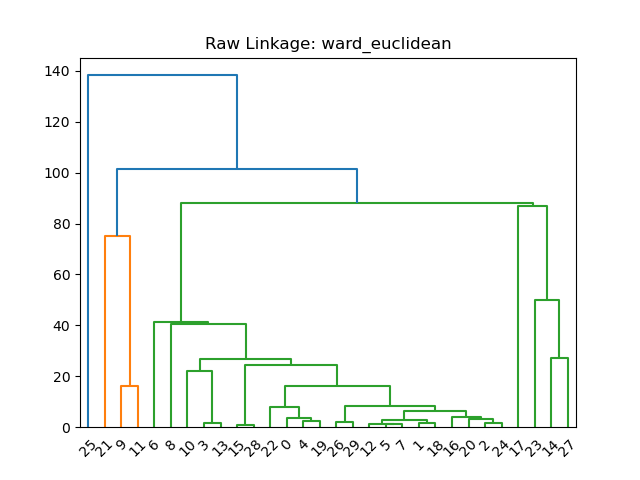

[25 21  9 11 17 27 14 23  8 10  3 13 26 29  1 18  7  5 12 16  2 24 20 22
  4 19  0 28 15  6]


<IPython.core.display.Javascript object>


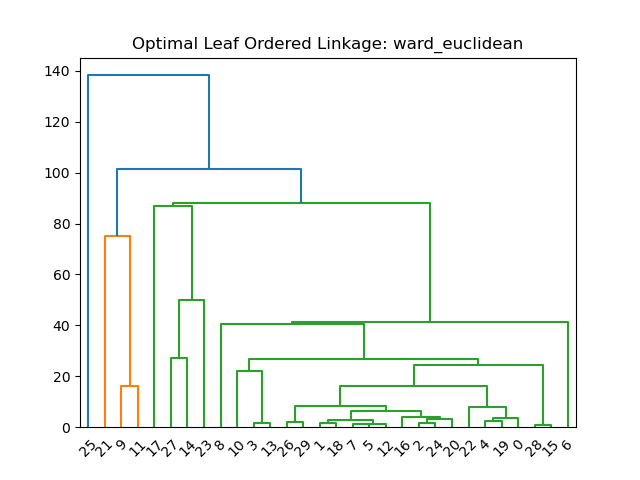

In [67]:
df_post_linkage, meta_data_df, linkage_cluster_order, Z_ordered, mpg_pca = dp.inter_cluster_sort(df_pre_linkage_ls,
                                                                             meta_data_df, 
                                                                             unique_labels,
                                                                             n_components = 10, 
                                                                             linkage_alg = linkage_alg,
                                                                             dist_metric = dist_metric)

In [68]:
linkage_cluster_order

array([25, 21,  9, 11, 17, 27, 14, 23,  8, 10,  3, 13, 26, 29,  1, 18,  7,
        5, 12, 16,  2, 24, 20, 22,  4, 19,  0, 28, 15,  6], dtype=int32)

In [69]:
df_post_linkage.head()

,CATCCACAGTGCACTT-1_10X35_1,GCTACAAAGCATGCAG-1_10X51_1,CCGTGAGTCACCTTAT-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,TCAGCAAGTGTAGTGG-1_10X52_3,TGCACGGCACACCGCA-1_10X35_2,GGTGGCTGTAGAATAC-1_10X38_1,CCTCAACGTTCAAACC-1_10X51_2,AGATGCTAGCCTAGGA-1_10X35_1,TAATTCCGTATCAGCT-1_10X35_2,...,ACGATGTTCTGATTCT-1_10X52_1,CCTTTGGTCATCTACT-1_10X51_1,ATGATCGTCTGAGTCA-1_10X51_2,GTGTAACGTCCGGTGT-1_10X51_2,TGCTTGCGTACCAGAG-1_10X51_3,AAGGAATAGCTAAGTA-1_10X37_1,CGGAACCAGTTGTCGT-1_10X52_1,AACAAAGCAGACAAAT-1_10X37_1,ATGCCTCCAACATCGT-1_10X51_1,ATTTCTGTCCACTAGA-1_10X52_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,...,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512
Oxt,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,...,5.909926,5.909926,11.918617,5.909926,15.433475,11.918617,5.909926,5.909926,-0.098764,-0.098764
Avp,-0.182275,1.829205,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,14.772329,18.080925,19.190643,13.734878,14.239884,15.178641,15.348560,16.663947,16.817165,14.158133
Plp1,-0.406017,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,0.852004,-0.406017,0.387706,-0.406017,...,-0.406017,0.387706,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,-0.406017,-0.406017,0.387706
Hba-a1,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,...,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357


In [70]:
meta_data_df.tail()

,CATCCACAGTGCACTT-1_10X35_1,GCTACAAAGCATGCAG-1_10X51_1,CCGTGAGTCACCTTAT-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,TCAGCAAGTGTAGTGG-1_10X52_3,TGCACGGCACACCGCA-1_10X35_2,GGTGGCTGTAGAATAC-1_10X38_1,CCTCAACGTTCAAACC-1_10X51_2,AGATGCTAGCCTAGGA-1_10X35_1,TAATTCCGTATCAGCT-1_10X35_2,...,ACGATGTTCTGATTCT-1_10X52_1,CCTTTGGTCATCTACT-1_10X51_1,ATGATCGTCTGAGTCA-1_10X51_2,GTGTAACGTCCGGTGT-1_10X51_2,TGCTTGCGTACCAGAG-1_10X51_3,AAGGAATAGCTAAGTA-1_10X37_1,CGGAACCAGTTGTCGT-1_10X52_1,AACAAAGCAGACAAAT-1_10X37_1,ATGCCTCCAACATCGT-1_10X51_1,ATTTCTGTCCACTAGA-1_10X52_2
LIbConstructionComment,,,,,,,,,,,...,,,,,,,,,,
ngperul_seqlib,13.6,19.2,13.6,22.0,20.4(second prep),17.6,15.0,22.2,13.6,17.6,...,15.7,19.2,22.2,22.2,22.0,15.9,15.7,15.9,19.2,17.5
lengthbp_seqlib,416.0,478.0,416.0,487.0,507.0,461.0,420.0,474.0,416.0,461.0,...,466.0,478.0,474.0,474.0,487.0,440.0,466.0,440.0,478.0,440.0
Sample_Index,D9,G1,D9,B2,F12,G8,B9,A2,D9,G8,...,D12,G1,A2,A2,B2,E9,D12,E9,G1,E12
cluster_label,25,25,25,25,25,25,25,25,25,25,...,6,6,6,6,6,6,6,6,6,6


verify cluster labels in metadata match linkage_cluster_order

In [71]:
l, idx = np.unique(np.array(meta_data_df.loc['cluster_label',:]), return_index=True)
l_ordered = l[np.argsort(idx)]
l_ordered

array([25, 21, 9, 11, 17, 27, 14, 23, 8, 10, 3, 13, 26, 29, 1, 18, 7, 5,
       12, 16, 2, 24, 20, 22, 4, 19, 0, 28, 15, 6], dtype=object)

In [72]:
df_post_linkage.shape

(744, 42644)

In [73]:
mpg_pca_df = pd.DataFrame(data = mpg_pca)

<IPython.core.display.Javascript object>


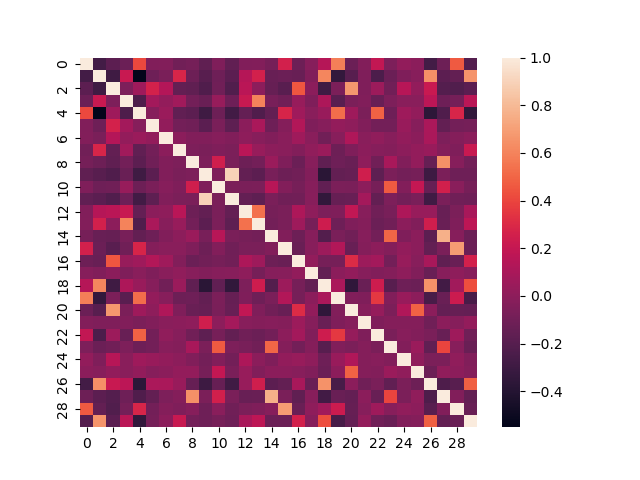

In [74]:
plt.figure()
ax = sns.heatmap(mpg_pca_df.corr(method='pearson'))
plt.show()

In [75]:
mpg_pca_pl_df = mpg_pca_df.reindex(columns = linkage_cluster_order)

<IPython.core.display.Javascript object>


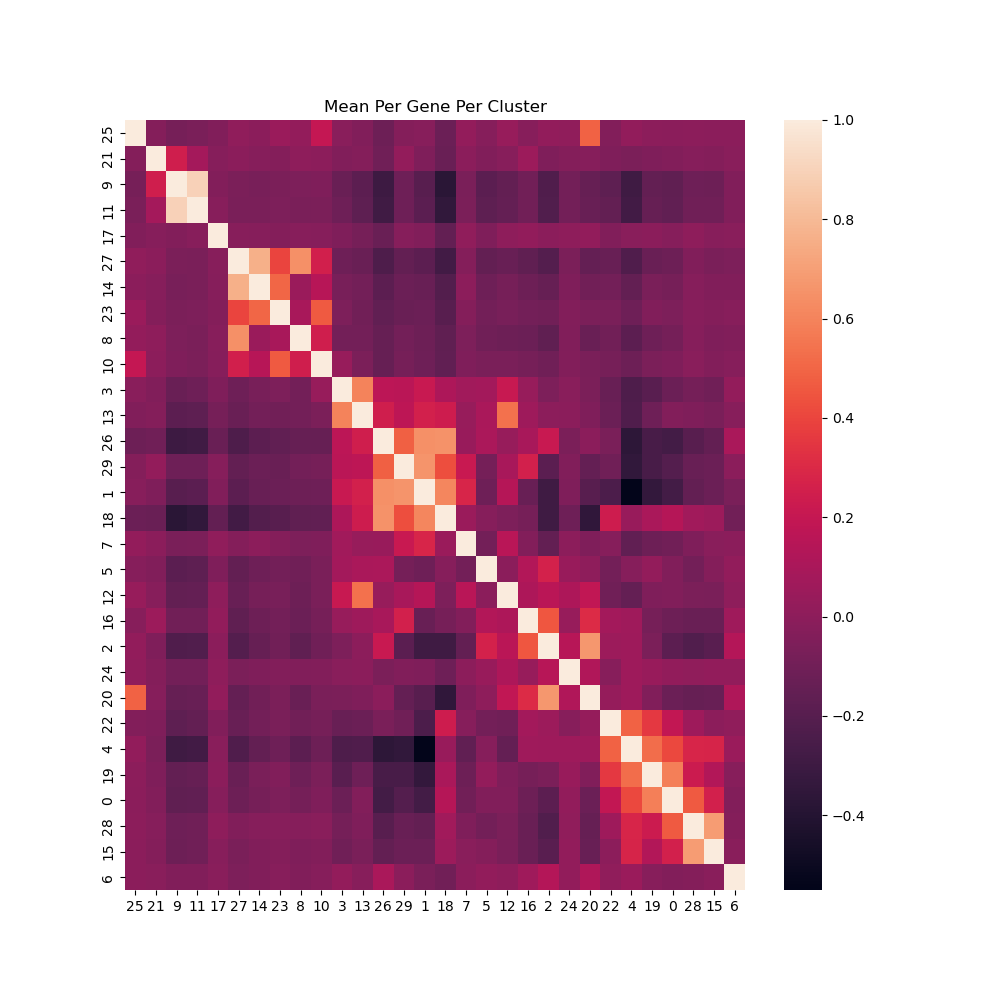

In [76]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(mpg_pca_pl_df.corr(method='pearson'), yticklabels=True, xticklabels=True)
plt.title('Mean Per Gene Per Cluster')
#plt.savefig('mpg_pca_corr_post_linkage')
plt.show()

Alternate approach using seaborn clustermap 

In [78]:
df_pre_linkage_ls.head()

gene,Hbb-bs,Oxt,Avp,Plp1,Hba-a1,Ptgds,Hba-a2,Hbb-bt,Acta2,Apoe,...,Ccdc153,Fam64a,Hpgds,Asic4,Fgfbp1,Rps27rt,Prox1os,Tmem47,Tns4,Dusp2
AAACCCAAGAGCATAT-1_10X51_2,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,0.990841,-0.047993,-0.028598,-0.076475,-0.41404,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,-0.721071,-0.226503,-0.697193,-0.022524,-0.138418
CACGAATGTTGTAGCT-1_10X51_1,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,-0.41404,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,1.637809,-0.226503,-0.697193,-0.022524,-0.138418
TTTAGTCAGCACTGGA-1_10X36_1,-0.063512,-0.098764,-0.182275,0.387706,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,-0.41404,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,-0.721071,-0.226503,-0.697193,-0.022524,-0.138418
AGAAATGTCGTGTGAT-1_10X51_4,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,-0.41404,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,0.767217,-0.226503,0.718921,-0.022524,-0.138418
TTTGATCTCACGGAGA-1_10X36_1,-0.063512,-0.098764,-0.182275,-0.406017,-0.035357,-0.241152,-0.047993,-0.028598,-0.076475,-0.41404,...,-0.162285,-0.03567,-0.312151,-0.176552,-0.030887,-0.721071,-0.226503,-0.697193,-0.022524,-0.138418


In [79]:
df_post_linkage.head()

,CATCCACAGTGCACTT-1_10X35_1,GCTACAAAGCATGCAG-1_10X51_1,CCGTGAGTCACCTTAT-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,TCAGCAAGTGTAGTGG-1_10X52_3,TGCACGGCACACCGCA-1_10X35_2,GGTGGCTGTAGAATAC-1_10X38_1,CCTCAACGTTCAAACC-1_10X51_2,AGATGCTAGCCTAGGA-1_10X35_1,TAATTCCGTATCAGCT-1_10X35_2,...,ACGATGTTCTGATTCT-1_10X52_1,CCTTTGGTCATCTACT-1_10X51_1,ATGATCGTCTGAGTCA-1_10X51_2,GTGTAACGTCCGGTGT-1_10X51_2,TGCTTGCGTACCAGAG-1_10X51_3,AAGGAATAGCTAAGTA-1_10X37_1,CGGAACCAGTTGTCGT-1_10X52_1,AACAAAGCAGACAAAT-1_10X37_1,ATGCCTCCAACATCGT-1_10X51_1,ATTTCTGTCCACTAGA-1_10X52_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,...,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512
Oxt,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,...,5.909926,5.909926,11.918617,5.909926,15.433475,11.918617,5.909926,5.909926,-0.098764,-0.098764
Avp,-0.182275,1.829205,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,14.772329,18.080925,19.190643,13.734878,14.239884,15.178641,15.348560,16.663947,16.817165,14.158133
Plp1,-0.406017,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,0.852004,-0.406017,0.387706,-0.406017,...,-0.406017,0.387706,-0.406017,-0.406017,-0.406017,0.387706,-0.406017,-0.406017,-0.406017,0.387706
Hba-a1,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,...,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357


### Intra Cluster sorting <a name="intra_cluster_sort"></a>

Intra cluster sorting  - For every unique cluster, perform 1D tsne, then use ascending TSNE values reshuffle within cluster

In [80]:
df_post_linkage_intra_sorted, meta_data_df, cluster_indices = dp.intra_cluster_sort(df_post_linkage, meta_data_df, linkage_cluster_order)

In [81]:
df_post_linkage_intra_sorted.head()

,ATGACCAAGGTAACTA-1_10X37_2,AGACAGGAGCATGATA-1_10X37_1,CCTCAACGTTCAAACC-1_10X51_2,CTGGACGTCGCTTGAA-1_10X35_2,CTGTACCCACTGCATA-1_10X37_2,CAGAGCCCATACAGGG-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,CAGCACGGTTTCGCTC-1_10X37_2,ATATCCTTCACATTGG-1_10X37_2,TGTAACGGTCAGGCAA-1_10X36_2,...,TCCCATGGTTTACGAC-1_10X52_1,CTGCAGGCAAGCGAAC-1_10X52_2,AGGGTCCTCCGGTTCT-1_10X35_2,AACAGGGCAGTGGTGA-1_10X52_2,GAGTGTTTCCGTGTGG-1_10X52_2,GTTGTAGGTCGCTTGG-1_10X51_2,ACTATTCGTGTGCCTG-1_10X38_1,GTGTAACCAGGTTTAC-1_10X52_2,GTAAGTCTCCGAACGC-1_10X37_2,TTCCGGTGTGCGGTAA-1_10X52_1
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,...,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512,-0.063512
Oxt,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,-0.098764,...,9.424785,-0.098764,11.918617,13.852983,22.136033,21.442166,30.470225,60.710613,66.672446,65.296260
Avp,1.829205,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,20.561880,17.153433,18.462386,18.414967,16.301312,19.255776,20.893523,3.005845,-0.182275,8.039574
Plp1,-0.406017,0.387706,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,-0.406017,...,-0.406017,0.387706,0.387706,1.181428,0.387706,-0.406017,-0.406017,0.852004,-0.406017,0.387706
Hba-a1,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,...,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357,-0.035357


In [82]:
meta_data_df.tail()

,ATGACCAAGGTAACTA-1_10X37_2,AGACAGGAGCATGATA-1_10X37_1,CCTCAACGTTCAAACC-1_10X51_2,CTGGACGTCGCTTGAA-1_10X35_2,CTGTACCCACTGCATA-1_10X37_2,CAGAGCCCATACAGGG-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,CAGCACGGTTTCGCTC-1_10X37_2,ATATCCTTCACATTGG-1_10X37_2,TGTAACGGTCAGGCAA-1_10X36_2,...,TCCCATGGTTTACGAC-1_10X52_1,CTGCAGGCAAGCGAAC-1_10X52_2,AGGGTCCTCCGGTTCT-1_10X35_2,AACAGGGCAGTGGTGA-1_10X52_2,GAGTGTTTCCGTGTGG-1_10X52_2,GTTGTAGGTCGCTTGG-1_10X51_2,ACTATTCGTGTGCCTG-1_10X38_1,GTGTAACCAGGTTTAC-1_10X52_2,GTAAGTCTCCGAACGC-1_10X37_2,TTCCGGTGTGCGGTAA-1_10X52_1
LIbConstructionComment,,,,,,,,,,,...,,,,,,,,,,
ngperul_seqlib,16.0,15.9,22.2,17.6,16.0,13.6,22.0,16.0,16.0,12.1,...,15.7,17.5,17.6,17.5,17.5,22.2,15.0,17.5,16.0,15.7
lengthbp_seqlib,460.0,440.0,474.0,461.0,460.0,416.0,487.0,460.0,460.0,486.0,...,466.0,440.0,461.0,440.0,440.0,474.0,420.0,440.0,460.0,466.0
Sample_Index,F9,E9,A2,G8,F9,D9,B2,F9,F9,A9,...,D12,E12,G8,E12,E12,A2,B9,E12,F9,D12
cluster_label,25,25,25,25,25,25,25,25,25,25,...,6,6,6,6,6,6,6,6,6,6


Verify cluster_label in meta data are still in same order (inter cluster order remains the same)

In [83]:
l, idx = np.unique(np.array(meta_data_df.loc['cluster_label',:]), return_index=True)
l_ordered = l[np.argsort(idx)]
l_ordered

array([25, 21, 9, 11, 17, 27, 14, 23, 8, 10, 3, 13, 26, 29, 1, 18, 7, 5,
       12, 16, 2, 24, 20, 22, 4, 19, 0, 28, 15, 6], dtype=object)

In [84]:
df_post_linkage_intra_sorted.shape

(744, 42644)

## Marker Genes<a name="markergenes"></a>

In [85]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [86]:
for c, idx in zip(linkage_cluster_order,cluster_indices):
    print (f'cluster {c}, num_cells {len(idx)}')

cluster 25, num_cells 35
cluster 21, num_cells 37
cluster 9, num_cells 760
cluster 11, num_cells 467
cluster 17, num_cells 193
cluster 27, num_cells 89
cluster 14, num_cells 724
cluster 23, num_cells 138
cluster 8, num_cells 1038
cluster 10, num_cells 451
cluster 3, num_cells 806
cluster 13, num_cells 272
cluster 26, num_cells 41
cluster 29, num_cells 76
cluster 1, num_cells 9860
cluster 18, num_cells 156
cluster 7, num_cells 460
cluster 5, num_cells 1626
cluster 12, num_cells 714
cluster 16, num_cells 70
cluster 2, num_cells 8553
cluster 24, num_cells 40
cluster 20, num_cells 70
cluster 22, num_cells 292
cluster 4, num_cells 13127
cluster 19, num_cells 162
cluster 0, num_cells 1667
cluster 28, num_cells 81
cluster 15, num_cells 539
cluster 6, num_cells 100


### Compute Markers <a name="compute_marker_genes"></a>

In [87]:
marker_genes_sorted, pos, ind, ind_s, mgs = dp.compute_marker_genes(df_post_linkage_intra_sorted,
                                                meta_data_df,
                                                cluster_indices,
                                                linkage_cluster_order,
                                                n_markers=5)

/home/isaac/analysis/scRNA-seq/dimorph_processing.py:659: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0_ind_arr = np.column_stack((xi0_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0_df.columns))))
/home/isaac/analysis/scRNA-seq/dimorph_processing.py:664: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  xi0p5_ind_arr = np.column_stack((xi0p5_df.iloc[:,i].sort_values(ascending=False).index for i in range(len(xi0p5_df.columns))))
/home/isaac/analysis/scRNA-seq/dimorph_processing.py:669: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is

[ 0  0  0  0 23  1  6 13 29 29 16 25  0 25  5 24  4  4  6 27  6  6  6  6
  7  7  7 29  0 19 29 16 10 12 17 10 11 11 12 23 29 12 12 15 16 16 17 17
 17 17 18 19 29 19 29  0 12 27 21 22 23 23 23 23 28 28 28 25 23 27 11 28
 28 29]
[ 0 12 55 28  2  1  3  5 16 17 14 23  6 21 20 22 18 24 26 25 32 35 37 70
 36 33 38 41 42 56  7 43 31 10 45 44 48 47 34 46 49 50 51 53 29 58 59 60
 61 62 63 68  4 39 15 13 11 67 19 57 69 64 71 72 65 66 27 52 30  9  8 40
 54 73]
len marker_genes_sorted_final 74


In [88]:
list(marker_genes_sorted)

['Pbk',
 'Stxbp6',
 'Zbtb18',
 'Cnr1',
 'Mki67',
 'Hist1h1b',
 'Kif14',
 'Gm13889',
 'Selplg',
 'Il1a',
 'Hmbs',
 'Ugt8a',
 'Ppp1r14a',
 'Gpr37',
 'Plp1',
 'Hapln2',
 'Evi2a',
 'Mbp',
 'Enpp6',
 'Bfsp2',
 'Slc30a3',
 'Rprm',
 'A830036E02Rik',
 'Thsd7a',
 'Ntng1',
 'Bcl11b',
 'A330069E16Rik',
 'Car12',
 'Bhlhe22',
 'Ngb',
 'Nr4a2',
 'Col25a1',
 'Rasl10a',
 'Serpini1',
 'Prox1os',
 'Grp',
 'Etl4',
 'Pbx3',
 'Hs3st4',
 'Abi3bp',
 'Meis1',
 'Snca',
 'Npas4',
 'Egr4',
 'Socs2',
 'Slc17a7',
 'Nptx1',
 'Gabre',
 'Calcr',
 'Cartpt',
 'Dlx1',
 'Satb1',
 'Calb2',
 'Gpr101',
 'Nfix',
 'Rcn1',
 'Etv1',
 'Sst',
 'Rgs10',
 'Cadps2',
 'Lhx6',
 'Gad2',
 'Dlx6os1',
 'Sema3e',
 'Gad1',
 'Mpped1',
 'Sv2b',
 'Gpx3',
 'C1ql2',
 'Parm1',
 'Myh7',
 'Avp',
 'Otp',
 'Gal']

list of indices corresponding to column with max value of marker array

In [89]:
ind

array([ 0,  0,  0,  0, 23,  1,  6, 13, 29, 29, 16, 25,  0, 25,  5, 24,  4,
        4,  6, 27,  6,  6,  6,  6,  7,  7,  7, 29,  0, 19, 29, 16, 10, 12,
       17, 10, 11, 11, 12, 23, 29, 12, 12, 15, 16, 16, 17, 17, 17, 17, 18,
       19, 29, 19, 29,  0, 12, 27, 21, 22, 23, 23, 23, 23, 28, 28, 28, 25,
       23, 27, 11, 28, 28, 29])

Sorted version of ind shown above, note 4 columns/clusters are missing (e.g. 8):

In [90]:
indy = np.sort(ind)
indy

array([ 0,  0,  0,  0,  0,  0,  0,  1,  4,  4,  5,  6,  6,  6,  6,  6,  6,
        7,  7,  7, 10, 10, 11, 11, 11, 12, 12, 12, 12, 12, 13, 15, 16, 16,
       16, 16, 17, 17, 17, 17, 17, 18, 19, 19, 19, 21, 22, 23, 23, 23, 23,
       23, 23, 23, 24, 25, 25, 25, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29,
       29, 29, 29, 29, 29, 29])

In [91]:
len(np.unique(indy))

23

In [92]:
len(linkage_cluster_order)

30

In [93]:
#np.argsort(np.sort(ind))

In [94]:
ind_s

array([ 0, 12, 55, 28,  2,  1,  3,  5, 16, 17, 14, 23,  6, 21, 20, 22, 18,
       24, 26, 25, 32, 35, 37, 70, 36, 33, 38, 41, 42, 56,  7, 43, 31, 10,
       45, 44, 48, 47, 34, 46, 49, 50, 51, 53, 29, 58, 59, 60, 61, 62, 63,
       68,  4, 39, 15, 13, 11, 67, 19, 57, 69, 64, 71, 72, 65, 66, 27, 52,
       30,  9,  8, 40, 54, 73])

In [95]:
len(indy)

74

In [96]:
ind_s[np.where(indy==0)]

array([ 0, 12, 55, 28,  2,  1,  3])

In [97]:
len(linkage_cluster_order)-1

29

In [98]:
g = []
for i in np.arange(0,len(np.unique(ind))):
    #print(i)
    x = ind_s[np.where(indy==i)]
    g.append(x)

In [99]:
g

[array([ 0, 12, 55, 28,  2,  1,  3]),
 array([5]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([16, 17]),
 array([14]),
 array([23,  6, 21, 20, 22, 18]),
 array([24, 26, 25]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([32, 35]),
 array([37, 70, 36]),
 array([33, 38, 41, 42, 56]),
 array([7]),
 array([], dtype=int64),
 array([43]),
 array([31, 10, 45, 44]),
 array([48, 47, 34, 46, 49]),
 array([50]),
 array([51, 53, 29]),
 array([], dtype=int64),
 array([58]),
 array([59])]

In [100]:
len(g)

23

In [101]:
tg = []
for i in g:
    gene = [mgs[x] for x in i]
    #print(gene)
    tg.append(gene)

In [102]:
marker_genes_sorted[:7]

['Pbk', 'Stxbp6', 'Zbtb18', 'Cnr1', 'Mki67', 'Hist1h1b', 'Kif14']

In [103]:
l=0
for i in tg:
    l+=len(i)
print(l)

47


In [104]:
tg

[['Pbk', 'Stxbp6', 'Zbtb18', 'Cnr1', 'Mki67', 'Hist1h1b', 'Kif14'],
 ['Gm13889'],
 [],
 [],
 ['Selplg', 'Il1a'],
 ['Hmbs'],
 ['Ugt8a', 'Ppp1r14a', 'Gpr37', 'Plp1', 'Hapln2', 'Evi2a'],
 ['Mbp', 'Enpp6', 'Bfsp2'],
 [],
 [],
 ['Slc30a3', 'Rprm'],
 ['A830036E02Rik', 'Thsd7a', 'Ntng1'],
 ['Bcl11b', 'A330069E16Rik', 'Car12', 'Bhlhe22', 'Ngb'],
 ['Nr4a2'],
 [],
 ['Col25a1'],
 ['Rasl10a', 'Serpini1', 'Prox1os', 'Grp'],
 ['Etl4', 'Pbx3', 'Hs3st4', 'Abi3bp', 'Meis1'],
 ['Snca'],
 ['Npas4', 'Egr4', 'Socs2'],
 [],
 ['Slc17a7'],
 ['Nptx1']]

In [105]:
'\n '.join(tg[0])

'Pbk\n Stxbp6\n Zbtb18\n Cnr1\n Mki67\n Hist1h1b\n Kif14'

In [106]:
tgf = []
for i,x in enumerate(tg):
    a = '\n '.join(tg[i])
    tgf.append(a)
    
    

In [107]:
tgf[0]

'Pbk\n Stxbp6\n Zbtb18\n Cnr1\n Mki67\n Hist1h1b\n Kif14'

Add space before 1st char in each tgf string to fix weird format issue

In [108]:
tgf

['Pbk\n Stxbp6\n Zbtb18\n Cnr1\n Mki67\n Hist1h1b\n Kif14',
 'Gm13889',
 '',
 '',
 'Selplg\n Il1a',
 'Hmbs',
 'Ugt8a\n Ppp1r14a\n Gpr37\n Plp1\n Hapln2\n Evi2a',
 'Mbp\n Enpp6\n Bfsp2',
 '',
 '',
 'Slc30a3\n Rprm',
 'A830036E02Rik\n Thsd7a\n Ntng1',
 'Bcl11b\n A330069E16Rik\n Car12\n Bhlhe22\n Ngb',
 'Nr4a2',
 '',
 'Col25a1',
 'Rasl10a\n Serpini1\n Prox1os\n Grp',
 'Etl4\n Pbx3\n Hs3st4\n Abi3bp\n Meis1',
 'Snca',
 'Npas4\n Egr4\n Socs2',
 '',
 'Slc17a7',
 'Nptx1']

In [109]:
tgfs = []
for i in tgf:
    x = ' ' + i
    tgfs.append(x)


In [110]:
tgfs

[' Pbk\n Stxbp6\n Zbtb18\n Cnr1\n Mki67\n Hist1h1b\n Kif14',
 ' Gm13889',
 ' ',
 ' ',
 ' Selplg\n Il1a',
 ' Hmbs',
 ' Ugt8a\n Ppp1r14a\n Gpr37\n Plp1\n Hapln2\n Evi2a',
 ' Mbp\n Enpp6\n Bfsp2',
 ' ',
 ' ',
 ' Slc30a3\n Rprm',
 ' A830036E02Rik\n Thsd7a\n Ntng1',
 ' Bcl11b\n A330069E16Rik\n Car12\n Bhlhe22\n Ngb',
 ' Nr4a2',
 ' ',
 ' Col25a1',
 ' Rasl10a\n Serpini1\n Prox1os\n Grp',
 ' Etl4\n Pbx3\n Hs3st4\n Abi3bp\n Meis1',
 ' Snca',
 ' Npas4\n Egr4\n Socs2',
 ' ',
 ' Slc17a7',
 ' Nptx1']

In [111]:
linkage_cluster_order

array([25, 21,  9, 11, 17, 27, 14, 23,  8, 10,  3, 13, 26, 29,  1, 18,  7,
        5, 12, 16,  2, 24, 20, 22,  4, 19,  0, 28, 15,  6], dtype=int32)

In [112]:
marker_genes_sorted

['Pbk',
 'Stxbp6',
 'Zbtb18',
 'Cnr1',
 'Mki67',
 'Hist1h1b',
 'Kif14',
 'Gm13889',
 'Selplg',
 'Il1a',
 'Hmbs',
 'Ugt8a',
 'Ppp1r14a',
 'Gpr37',
 'Plp1',
 'Hapln2',
 'Evi2a',
 'Mbp',
 'Enpp6',
 'Bfsp2',
 'Slc30a3',
 'Rprm',
 'A830036E02Rik',
 'Thsd7a',
 'Ntng1',
 'Bcl11b',
 'A330069E16Rik',
 'Car12',
 'Bhlhe22',
 'Ngb',
 'Nr4a2',
 'Col25a1',
 'Rasl10a',
 'Serpini1',
 'Prox1os',
 'Grp',
 'Etl4',
 'Pbx3',
 'Hs3st4',
 'Abi3bp',
 'Meis1',
 'Snca',
 'Npas4',
 'Egr4',
 'Socs2',
 'Slc17a7',
 'Nptx1',
 'Gabre',
 'Calcr',
 'Cartpt',
 'Dlx1',
 'Satb1',
 'Calb2',
 'Gpr101',
 'Nfix',
 'Rcn1',
 'Etv1',
 'Sst',
 'Rgs10',
 'Cadps2',
 'Lhx6',
 'Gad2',
 'Dlx6os1',
 'Sema3e',
 'Gad1',
 'Mpped1',
 'Sv2b',
 'Gpx3',
 'C1ql2',
 'Parm1',
 'Myh7',
 'Avp',
 'Otp',
 'Gal']

In [113]:
len(cluster_indices[0])

35

In [114]:
df_marker = df_post_linkage_intra_sorted.loc[marker_genes_sorted,:]

In [115]:
df_marker.shape

(74, 42644)

In [116]:
df_marker.head()

,ATGACCAAGGTAACTA-1_10X37_2,AGACAGGAGCATGATA-1_10X37_1,CCTCAACGTTCAAACC-1_10X51_2,CTGGACGTCGCTTGAA-1_10X35_2,CTGTACCCACTGCATA-1_10X37_2,CAGAGCCCATACAGGG-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,CAGCACGGTTTCGCTC-1_10X37_2,ATATCCTTCACATTGG-1_10X37_2,TGTAACGGTCAGGCAA-1_10X36_2,...,TCCCATGGTTTACGAC-1_10X52_1,CTGCAGGCAAGCGAAC-1_10X52_2,AGGGTCCTCCGGTTCT-1_10X35_2,AACAGGGCAGTGGTGA-1_10X52_2,GAGTGTTTCCGTGTGG-1_10X52_2,GTTGTAGGTCGCTTGG-1_10X51_2,ACTATTCGTGTGCCTG-1_10X38_1,GTGTAACCAGGTTTAC-1_10X52_2,GTAAGTCTCCGAACGC-1_10X37_2,TTCCGGTGTGCGGTAA-1_10X52_1
gene,,,,,,,,,,,,,,,,,,,,,
Pbk,58.856553,28.066772,56.162118,35.423806,28.066772,41.130364,-0.028573,45.792962,45.792962,41.130364,...,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573
Stxbp6,0.670455,0.670455,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,...,0.670455,1.428536,1.428536,0.670455,1.428536,1.966402,1.428536,1.966402,1.966402,3.679550
Zbtb18,-0.682272,0.415187,0.415187,-0.682272,-0.682272,-0.682272,-0.682272,0.415187,0.415187,-0.682272,...,-0.682272,-0.682272,-0.682272,1.057159,-0.682272,0.415187,0.415187,0.415187,0.415187,0.415187
Cnr1,-0.604498,-0.604498,1.083946,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,...,1.083946,0.460792,0.460792,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498
Mki67,22.341092,18.973275,24.304551,19.764927,13.215954,16.010712,14.730328,13.215954,23.855465,17.119832,...,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130


### Heatmap <a name="marker_heatmap"></a>

First, standerdize the marker dataframe

In [122]:
#marker_log_and_std_arr, status_df = dp.log_and_standerdize_df(df_marker,status_df, log = False)

column (gene) mean after standardization: 0.00
column (gene) sigma after standardization: 1.00


In [123]:
#marker_log_and_std_arr.T.shape

(177, 42647)

In [124]:
#df_marker_log_and_std = pd.DataFrame(index = df_marker.index, columns=df_post_linkage_intra_sorted.columns, data = marker_log_and_std_arr.T)

In [118]:
df_marker_log_and_std = df_marker.copy()

In [119]:
df_marker.shape

(74, 42644)

In [120]:
df_marker_log_and_std.shape

(74, 42644)

In [121]:
df_marker_log_and_std.head()

,ATGACCAAGGTAACTA-1_10X37_2,AGACAGGAGCATGATA-1_10X37_1,CCTCAACGTTCAAACC-1_10X51_2,CTGGACGTCGCTTGAA-1_10X35_2,CTGTACCCACTGCATA-1_10X37_2,CAGAGCCCATACAGGG-1_10X35_1,CTATCTATCATTTGGG-1_10X51_3,CAGCACGGTTTCGCTC-1_10X37_2,ATATCCTTCACATTGG-1_10X37_2,TGTAACGGTCAGGCAA-1_10X36_2,...,TCCCATGGTTTACGAC-1_10X52_1,CTGCAGGCAAGCGAAC-1_10X52_2,AGGGTCCTCCGGTTCT-1_10X35_2,AACAGGGCAGTGGTGA-1_10X52_2,GAGTGTTTCCGTGTGG-1_10X52_2,GTTGTAGGTCGCTTGG-1_10X51_2,ACTATTCGTGTGCCTG-1_10X38_1,GTGTAACCAGGTTTAC-1_10X52_2,GTAAGTCTCCGAACGC-1_10X37_2,TTCCGGTGTGCGGTAA-1_10X52_1
gene,,,,,,,,,,,,,,,,,,,,,
Pbk,58.856553,28.066772,56.162118,35.423806,28.066772,41.130364,-0.028573,45.792962,45.792962,41.130364,...,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573
Stxbp6,0.670455,0.670455,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,...,0.670455,1.428536,1.428536,0.670455,1.428536,1.966402,1.428536,1.966402,1.966402,3.679550
Zbtb18,-0.682272,0.415187,0.415187,-0.682272,-0.682272,-0.682272,-0.682272,0.415187,0.415187,-0.682272,...,-0.682272,-0.682272,-0.682272,1.057159,-0.682272,0.415187,0.415187,0.415187,0.415187,0.415187
Cnr1,-0.604498,-0.604498,1.083946,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,...,1.083946,0.460792,0.460792,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498
Mki67,22.341092,18.973275,24.304551,19.764927,13.215954,16.010712,14.730328,13.215954,23.855465,17.119832,...,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130


Write to file

In [122]:
pwd

'/home/isaac/analysis/scRNA-seq'

In [125]:
outfile_name = 'df_marker_pre_linkage_ls'
#df_marker_log_and_std.to_feather('/bigdata/isaac/'+outfile_name+'.feather')
#df_marker_log_and_std = pd.read_feather('/bigdata/isaac/df_marker_log_and_std.feather')

In [126]:
outfile_name = 'metadata_df_marker_pre_linkage_ls'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')
#metadata_df_marker_log_and_std = pd.read_json('/bigdata/isaac/metadata_df_marker_log_and_std.json')

<IPython.core.display.Javascript object>


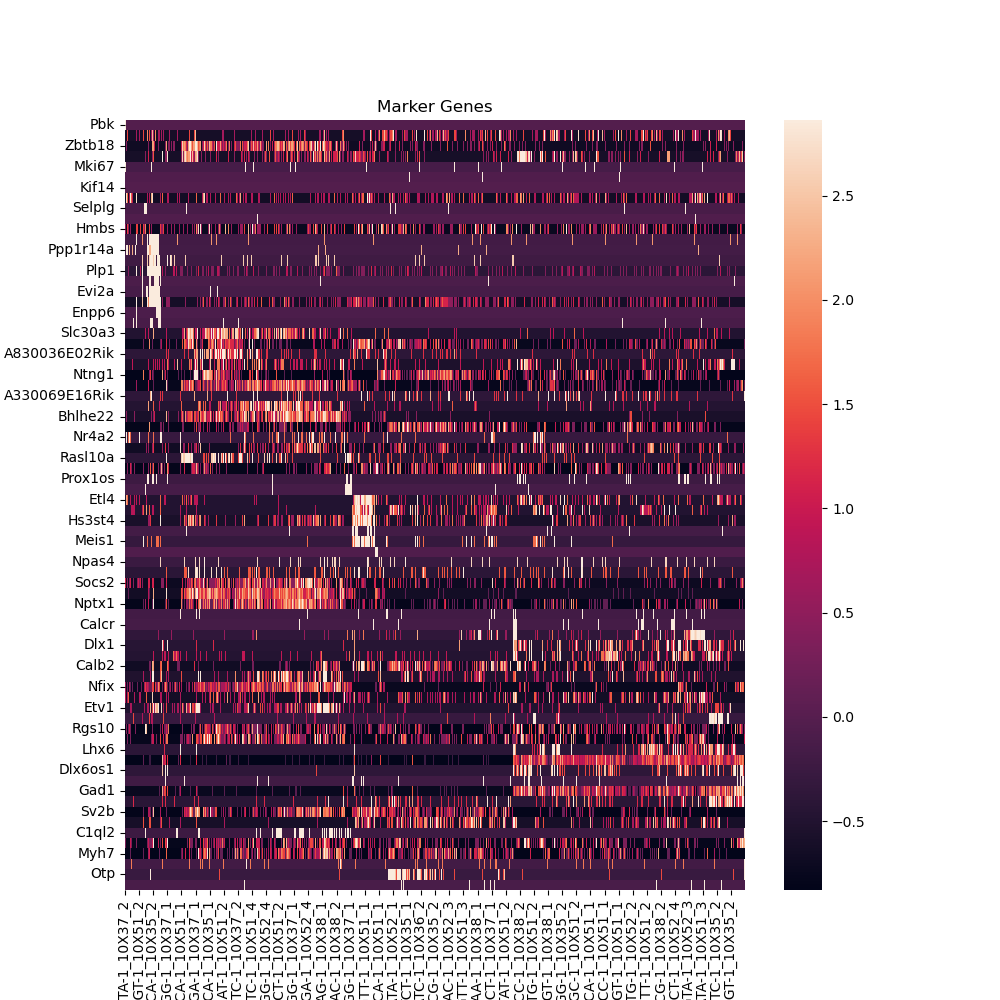

In [127]:
ax, fig = plt.subplots(figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
#to display all ticks, use: xticklabels=True, yticklabels=True
plt.title('Marker Genes')
sns.heatmap(df_marker_log_and_std, robust=True)
plt.show()

Update plot to show average cluster position

In [128]:
df_marker_log_and_std_col = pd.DataFrame(data = df_marker_log_and_std.to_numpy(), 
                                         index = df_marker_log_and_std.index,
                                        columns = list(meta_data_df.loc['cluster_label',:]))

In [129]:
df_marker_log_and_std_col

,25,25,25,25,25,25,25,25,25,25,...,6,6,6,6,6,6,6,6,6,6
gene,,,,,,,,,,,,,,,,,,,,,
Pbk,58.856553,28.066772,56.162118,35.423806,28.066772,41.130364,-0.028573,45.792962,45.792962,41.130364,...,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573,-0.028573
Stxbp6,0.670455,0.670455,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,-0.625491,...,0.670455,1.428536,1.428536,0.670455,1.428536,1.966402,1.428536,1.966402,1.966402,3.679550
Zbtb18,-0.682272,0.415187,0.415187,-0.682272,-0.682272,-0.682272,-0.682272,0.415187,0.415187,-0.682272,...,-0.682272,-0.682272,-0.682272,1.057159,-0.682272,0.415187,0.415187,0.415187,0.415187,0.415187
Cnr1,-0.604498,-0.604498,1.083946,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,...,1.083946,0.460792,0.460792,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498,-0.604498
Mki67,22.341092,18.973275,24.304551,19.764927,13.215954,16.010712,14.730328,13.215954,23.855465,17.119832,...,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130,-0.152130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Parm1,-0.783717,-0.783717,-0.783717,-0.783717,-0.783717,-0.783717,-0.783717,-0.783717,-0.783717,-0.783717,...,2.095329,2.557585,3.947486,2.557585,0.981562,2.746842,3.069285,2.095329,3.337711,2.343023
Myh7,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,...,-0.834628,-0.834628,0.122621,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,-0.834628,0.122621
Avp,1.829205,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,-0.182275,...,20.561880,17.153433,18.462386,18.414967,16.301312,19.255776,20.893523,3.005845,-0.182275,8.039574


In [130]:
x = list(meta_data_df.loc['cluster_label',:])
change_indices = [0]  # Initialize with the index of the first element

# Iterate through the list starting from the second element
for i in range(1, len(x)):
    # Check if the current value is different from the previous value
    if x[i] != x[i - 1]:
        # If a change is detected, append the index to the list
        change_indices.append(i)

print("Indices where the value changes:", change_indices)

change_indices = change_indices[1:] #ignore initial value set

Indices where the value changes: [0, 35, 72, 832, 1299, 1492, 1581, 2305, 2443, 3481, 3932, 4738, 5010, 5051, 5127, 14987, 15143, 15603, 17229, 17943, 18013, 26566, 26606, 26676, 26968, 40095, 40257, 41924, 42005, 42544]


<IPython.core.display.Javascript object>


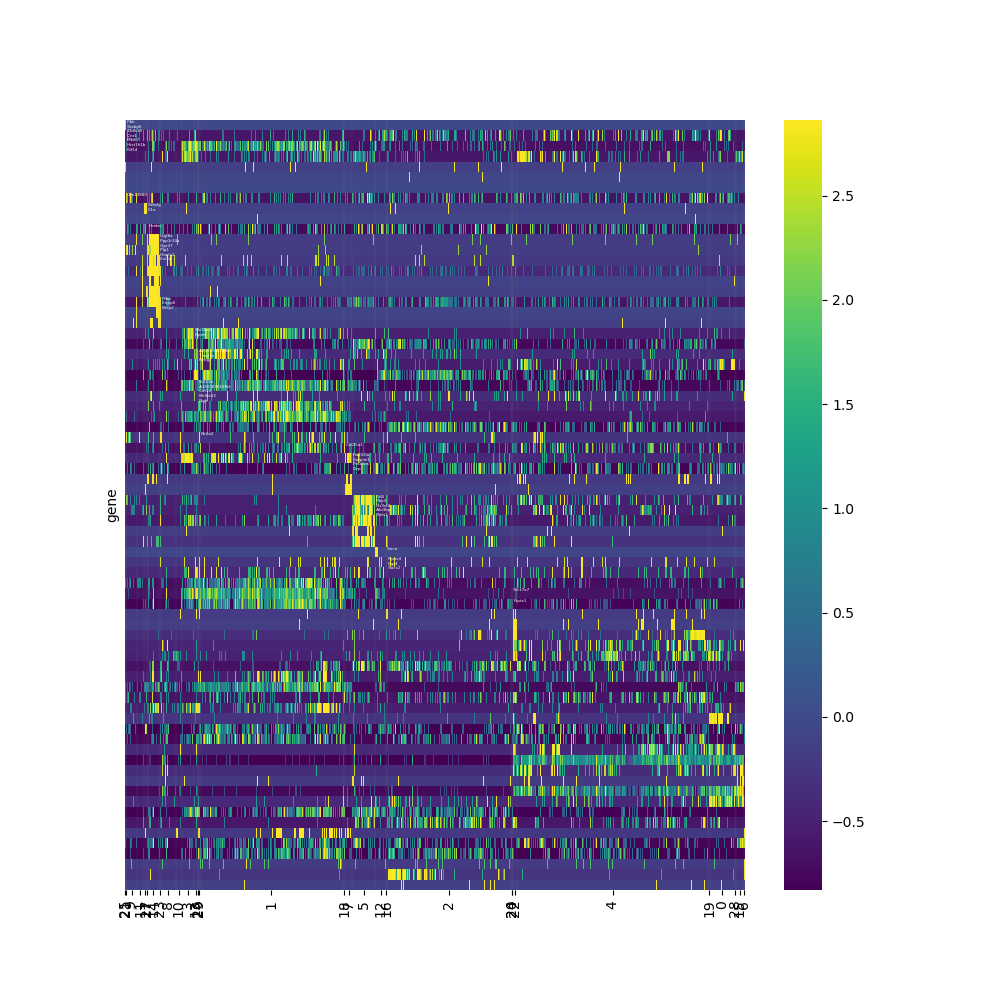

In [134]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_marker_log_and_std_col, robust=True,  cmap="viridis", yticklabels=True)
ax.set_xticks(ticks = pos, labels = linkage_cluster_order)
#ax.set_xticks([])
#ax.set_xticklabels([])
#ax.set_yticks(ticks = np.arange(0,len(df_marker_log_and_std_col.index)), labels = np.arange(0,len(df_marker_log_and_std_col.index)))
ax.set_yticks([])
ax.vlines(change_indices, -100 ,300, colors='gray', lw = 0.1)
#plt.text(change_indices[0],0, tgf_test, 
#             verticalalignment='top', horizontalalignment = 'left', color="white", fontsize = 2.9)

ypos = 0
#xpos = change_indices[0]

for i,v in enumerate(tg):
    xpos = change_indices[i]
    plt.text(xpos,ypos, tgfs[i], 
             verticalalignment='top', horizontalalignment = 'left', color="white", fontsize = 2.9)
    ypos+=int(len(tg[i]))

    #print (xpos)
    
#plt.savefig('heatmap_test_linkage_'+linkage_alg+'_'+dist_metric+'.png', dpi = 1200)
#plt.savefig('heatmap_test_pre_linkage_ls'+linkage_alg+'_'+dist_metric+'.png', dpi = 1200)

plt.show()

<IPython.core.display.Javascript object>


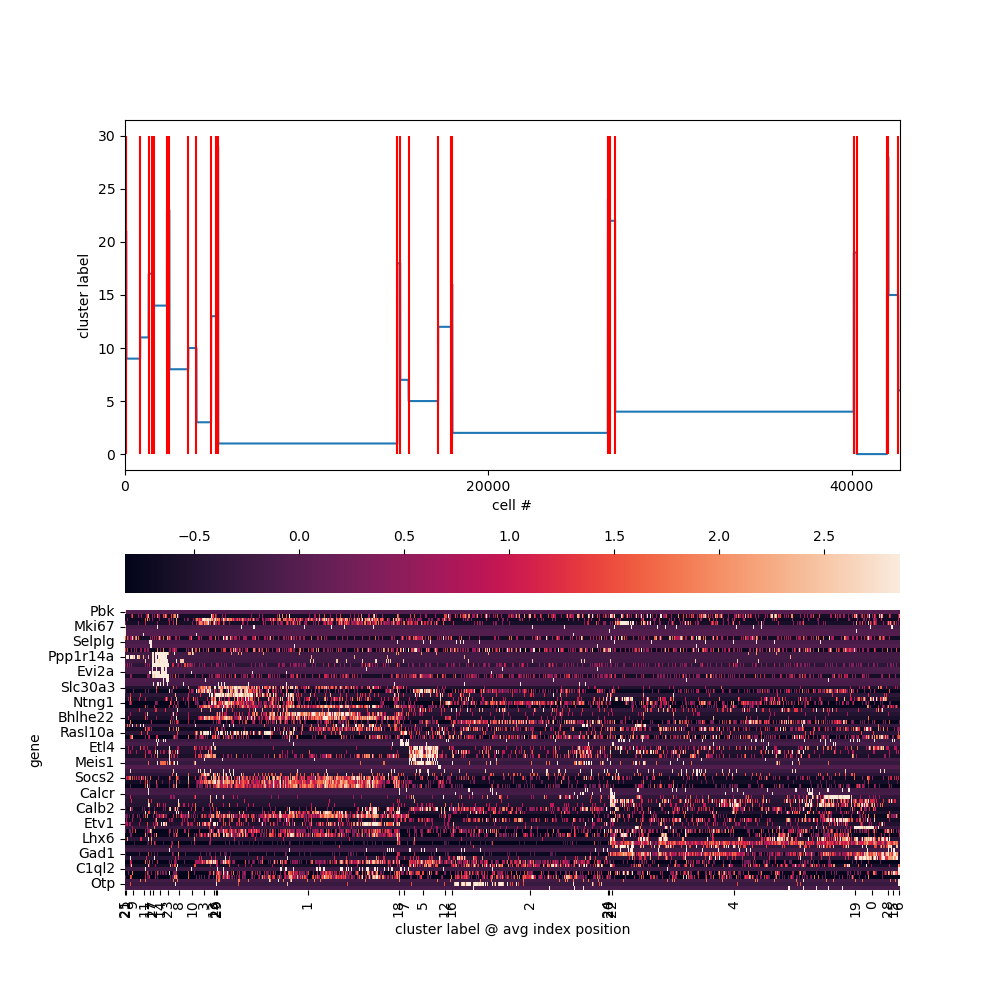

In [132]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
#to display all ticks, use: xticklabels=True, yticklabels=True

ax1.plot(np.array(meta_data_df.loc['cluster_label',:]))
ax1.set_xticks(ticks = [0, 20000, 40000])
ax1.margins(x=0)
ax1.set_xlabel('cell #')
ax1.set_ylabel('cluster label')
ax1.vlines(change_indices, 0 ,30, colors='r')

#plt.title('Heatmap using  column major F style')
#to move colorbar to top, add code below to .heatmap call
#cbar_kws=dict(location = 'top')
ax2 = sns.heatmap(df_marker_log_and_std_col, robust=True,cbar_kws=dict(location = 'top'))
ax2.set_xticks(ticks = pos, labels = linkage_cluster_order)
ax2.set_xlabel('cluster label @ avg index position')

plt.show()

In [133]:
df_marker_log_and_std_col

,28,28,28,28,28,28,28,28,28,28,...,11,11,11,11,11,11,11,11,11,11
gene,,,,,,,,,,,,,,,,,,,,,
Itih3,6.870842,2.213731,-0.114825,11.527954,2.213731,-0.114825,6.870842,9.199398,-0.114825,4.542287,...,-0.114825,-0.114825,-0.114825,-0.114825,-0.114825,-0.114825,-0.114825,-0.114825,-0.114825,-0.114825
Slc7a10,-0.123340,6.616031,3.246346,3.246346,3.246346,3.246346,3.246346,9.985717,6.616031,3.246346,...,-0.123340,-0.123340,-0.123340,-0.123340,-0.123340,-0.123340,-0.123340,-0.123340,-0.123340,-0.123340
Ptgds,4.833450,2.404507,3.445483,4.139466,0.149060,0.062312,1.363532,1.016540,1.016540,1.276784,...,-0.024436,-0.024436,-0.111184,-0.111184,-0.111184,-0.111184,-0.111184,-0.111184,-0.111184,-0.111184
Il33,10.147138,3.294784,5.007873,6.720961,-0.131393,1.581696,6.720961,3.294784,-0.131393,3.294784,...,-0.131393,-0.131393,-0.131393,-0.131393,-0.131393,-0.131393,-0.131393,-0.131393,-0.131393,-0.131393
Gjb6,8.993686,2.910746,12.035157,2.910746,8.993686,-0.130725,5.952216,-0.130725,2.910746,12.035157,...,-0.130725,-0.130725,-0.130725,-0.130725,-0.130725,-0.130725,-0.130725,-0.130725,-0.130725,-0.130725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vtn,-0.103716,-0.103716,-0.103716,-0.103716,-0.103716,-0.103716,-0.103716,-0.103716,-0.103716,-0.103716,...,-0.103716,-0.103716,-0.103716,-0.103716,0.737432,-0.103716,1.158006,-0.103716,0.316858,-0.103716
Flt1,-0.144438,-0.144438,-0.144438,-0.144438,-0.144438,-0.144438,-0.144438,-0.144438,-0.144438,-0.144438,...,7.171316,11.194980,13.938388,8.451572,7.354209,17.413371,9.000254,7.537103,15.584433,12.109449
Ndufa4l2,-0.128267,-0.128267,-0.128267,-0.128267,-0.128267,-0.128267,-0.128267,-0.128267,-0.128267,-0.128267,...,-0.128267,-0.128267,1.399299,-0.128267,-0.128267,1.399299,1.399299,-0.128267,1.399299,-0.128267


<IPython.core.display.Javascript object>


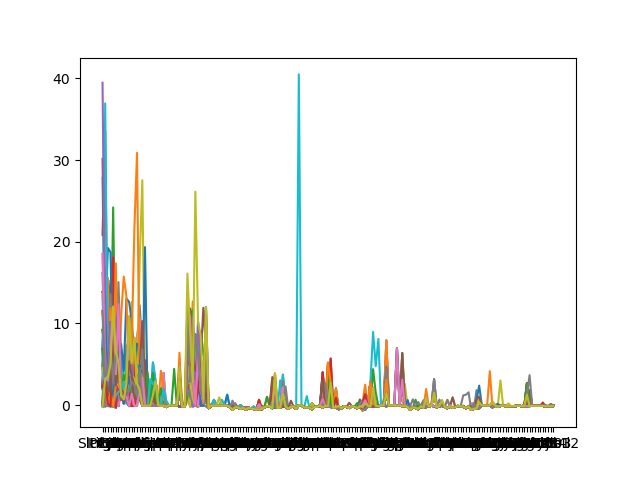

In [1353]:
fig,ax = plt.subplots()
#ax.plot(xi0p5_marker[:,linkage_cluster_order[0]])
ax.plot(df_marker_log_and_std_col.loc[:,df_marker_log_and_std_col.columns == 27])
plt.show()

Further analysis

In [1354]:
list(marker_genes_sorted)

['Itih3',
 'Slc7a10',
 'Ptgds',
 'Il33',
 'Gjb6',
 'Cd63',
 'Agt',
 'Plp1',
 'Mobp',
 'Mal',
 'Aspa',
 'Ermn',
 'Opalin',
 'Mog',
 'Trf',
 'Gjb1',
 'Bfsp2',
 'Neu4',
 'Bmp4',
 'Bcas1',
 'Cnksr3',
 'Folr2',
 'Gpr17',
 'Enpp6',
 'Otp',
 'Oxt',
 'Avp',
 'Ebf3',
 'Pla2r1',
 'Pou3f2',
 'Pdyn',
 'C1ql2',
 'Apoe',
 'Ntsr2',
 'Mlc1',
 'Lcat',
 'Slc25a18',
 'Aqp4',
 'Gfap',
 'Gja1',
 'Junb',
 'Ctss',
 'C1qa',
 'Bcl2a1b',
 'C1qc',
 'C1qb',
 'Siglech',
 'Cx3cr1',
 'Vgll3',
 'Ngb',
 'Penk',
 'Krt9',
 'Bhlhe22',
 'Cd24a',
 'Nptx1',
 'Lpl',
 'Car12',
 'Crym',
 'Ntng1',
 'Rmst',
 'Slc17a7',
 'Krt12',
 'Cyp26b1',
 'Neurod6',
 'Igfbp5',
 'Rorb',
 'Rasgrp1',
 '3110035E14Rik',
 'Pou3f1',
 'C1ql1',
 'Neurod2',
 'Cbln2',
 'Sim1',
 'Calb2',
 'Clec10a',
 'Mgl2',
 'Adcyap1',
 'Igfbp6',
 'Egr4',
 'Unc13c',
 'Npas4',
 'Fosb',
 'Snca',
 'Prox1',
 'Grp',
 'Fbln1',
 'Prox1os',
 'Rasl10a',
 'Meis1',
 'Slc17a6',
 'Hs3st4',
 'Abi3bp',
 'Nxph4',
 'Etl4',
 'Rxfp1',
 'Nr4a2',
 'Bdnf',
 'Dcn',
 'Nfib',
 'Nfix',
 'Fam89a'

gene in df?  True
gene index:  [82]


<IPython.core.display.Javascript object>


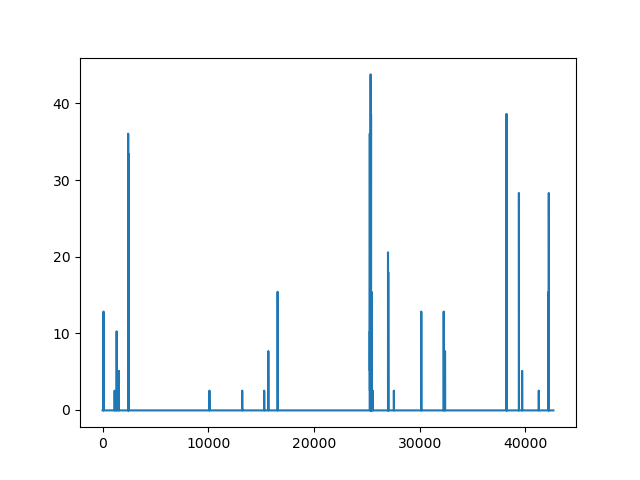

In [1355]:
gene = 'Snca'
print('gene in df? ', gene in df_marker_log_and_std.index)
gene_index = np.where(df_marker_log_and_std.index == gene)[0]
print ('gene index: ', gene_index)
#get row data
x = df_marker_log_and_std.iloc[gene_index,:]
fig,ax = plt.subplots()
plt.plot(np.array(x.iloc[0,:]))
plt.show()

In [1356]:
linkage_cluster_order

array([27, 14, 23,  6,  8, 17, 26, 13,  3,  4, 24, 20,  2, 16, 12,  7,  5,
        1, 29, 18, 10, 25, 15, 28,  0, 19, 22, 21,  9, 11], dtype=int32)

/tmp/ipykernel_3233204/2220817324.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots()


<IPython.core.display.Javascript object>


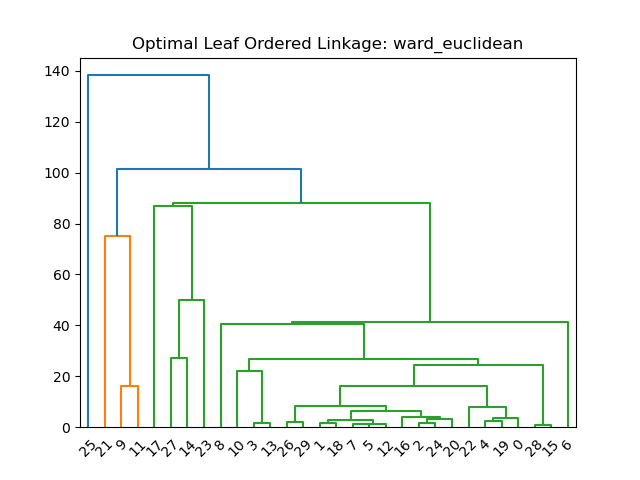

<IPython.core.display.Javascript object>


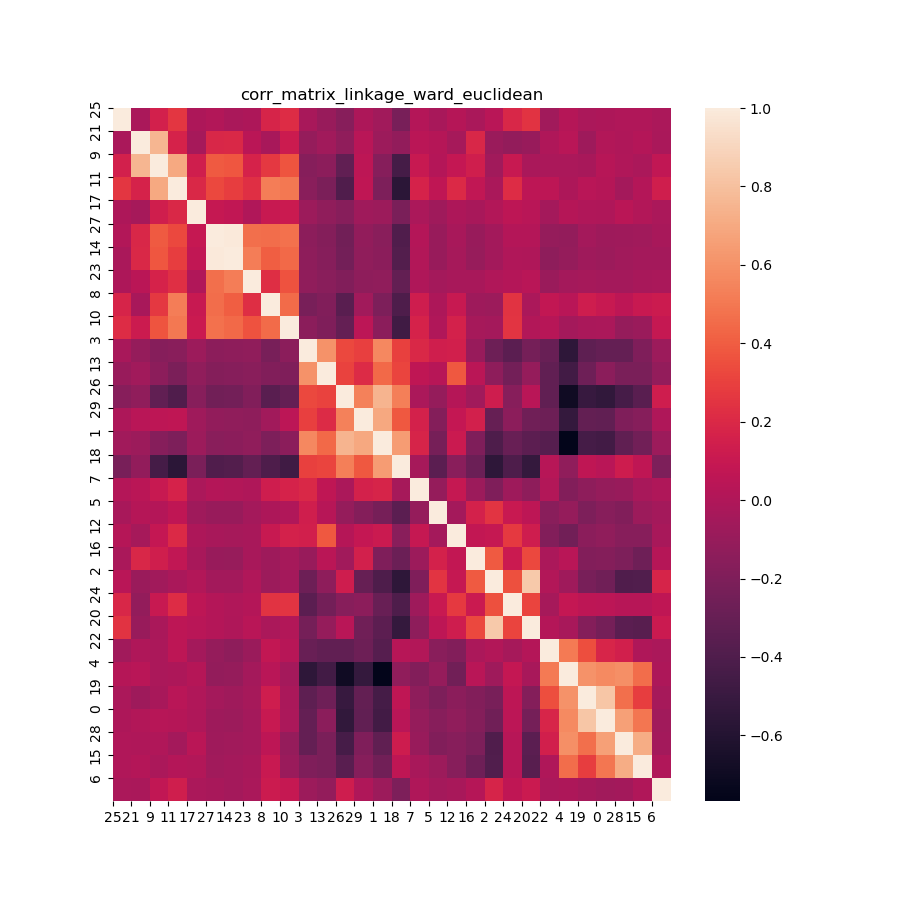

In [133]:
mean_per_gene_per_cluster_arr = np.zeros((len(df_marker_log_and_std_col.index),len(unique_labels)))
for idx, c in enumerate(zip(linkage_cluster_order,cluster_indices)):
    #compute mean expression for each cluster in linkage cluster order
    #print (idx)
    #print (c[0])
    cluster_mean_expr = np.mean(df_marker.loc[:,meta_data_df.loc['cluster_label',:] == c[0]], axis = 1)
    #print (cluster_mean_expr)
    mean_per_gene_per_cluster_arr[:,idx] = cluster_mean_expr

mean_per_gene_per_cluster_df = pd.DataFrame(data = mean_per_gene_per_cluster_arr)
fig,ax = plt.subplots()
#plt.figure(figsize=(10,10))
ax.set_title('Optimal Leaf Ordered Linkage: ' + linkage_alg + '_' + dist_metric)
dn = dendrogram(Z_ordered)
plt.show()

fig,ax = plt.subplots(figsize = (9,9))
ax = sns.heatmap(mean_per_gene_per_cluster_df.corr())
ax.set_title('corr_matrix_linkage_'+linkage_alg+'_'+dist_metric)
ax.set_xticks(ticks = np.arange(0,len(linkage_cluster_order)), labels = linkage_cluster_order)
ax.set_yticks(ticks = np.arange(0,len(linkage_cluster_order)), labels = linkage_cluster_order)
#plt.savefig('corr_matrix_linkage_'+linkage_alg+'_'+dist_metric)
plt.show()

In [135]:
mean_per_gene_per_cluster_df.corr()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1.000000,0.962143,0.925420,-0.012889,0.208295,0.403568,-0.006099,-0.026958,-0.024994,-0.008573,...,0.060798,-0.021667,-0.019476,-0.025611,-0.015983,-0.016157,-0.021219,0.011473,-0.004276,0.015001
1,0.962143,1.000000,0.985270,-0.008335,0.010174,0.398852,0.008026,-0.016634,-0.012607,0.007105,...,-0.003717,-0.008214,-0.006604,-0.011867,-0.001693,-0.000987,-0.011308,0.015073,-0.011401,0.009768
2,0.925420,0.985270,1.000000,-0.008235,0.007155,0.394671,0.007338,-0.015483,-0.009657,0.007621,...,0.006050,-0.008174,-0.006183,-0.011859,-0.000820,0.000351,-0.009773,0.014947,-0.015054,0.005289
3,-0.012889,-0.008335,-0.008235,1.000000,-0.002157,-0.024031,0.610819,-0.021635,-0.018463,-0.011919,...,-0.023533,-0.018542,-0.019621,-0.021285,-0.018179,-0.019545,-0.016264,-0.021044,-0.026270,-0.009561
4,0.208295,0.010174,0.007155,-0.002157,1.000000,0.136674,0.044068,0.026357,-0.009410,0.082398,...,0.310833,0.067127,0.071667,0.037115,0.042480,0.059541,0.034331,-0.000754,0.023914,0.025756
5,0.403568,0.398852,0.394671,-0.024031,0.136674,1.000000,0.033885,-0.007897,-0.011463,0.129114,...,0.029280,0.085412,0.094367,0.060680,0.071893,0.080954,0.029570,0.095298,0.046334,0.042295
6,-0.006099,0.008026,0.007338,0.610819,0.044068,0.033885,1.000000,0.364326,0.274841,0.074829,...,0.026186,0.045035,0.044652,-0.007167,-0.024810,-0.024684,-0.000633,0.011935,-0.053792,-0.018841
7,-0.026958,-0.016634,-0.015483,-0.021635,0.026357,-0.007897,0.364326,1.000000,0.566171,0.091636,...,-0.035778,-0.008598,-0.011104,-0.010388,0.005095,0.019892,-0.016215,-0.000334,-0.071766,-0.046866
8,-0.024994,-0.012607,-0.009657,-0.018463,-0.009410,-0.011463,0.274841,0.566171,1.000000,0.005664,...,0.036336,-0.034975,-0.033175,-0.034841,-0.027898,0.019748,-0.032525,-0.007794,-0.074739,-0.053242
9,-0.008573,0.007105,0.007621,-0.011919,0.082398,0.129114,0.074829,0.091636,0.005664,1.000000,...,-0.024613,0.807486,0.834142,0.602264,0.651452,0.878884,0.597049,0.080748,-0.043296,-0.011290


In [136]:
mpg_pca_pl_df.corr()

,28,14,24,6,8,17,27,13,3,4,...,26,15,29,0,19,21,23,22,9,11
28,1.000000,0.944637,0.888119,-0.006047,0.287171,0.347138,0.014978,-0.001163,-0.003377,0.006266,...,0.110822,-0.000428,0.010542,-0.007296,-0.002855,-0.000552,-0.009367,0.035501,0.037283,0.015582
14,0.944637,1.000000,0.959599,-0.002040,0.022363,0.322823,0.023580,0.005165,0.005014,0.018207,...,0.019281,0.009086,0.015304,0.003750,0.010600,0.008693,0.000423,0.025086,-0.003842,0.004883
24,0.888119,0.959599,1.000000,-0.003660,0.024925,0.312812,0.026581,0.000816,0.004901,0.020021,...,0.040200,0.006324,0.011442,0.002307,0.010963,0.007034,0.002334,0.019552,-0.012669,-0.002710
6,-0.006047,-0.002040,-0.003660,1.000000,0.001903,-0.009308,0.486808,-0.002708,-0.001630,0.006202,...,-0.008737,-0.002310,-0.006112,-0.005539,-0.003676,0.002434,-0.002254,-0.008597,-0.014689,-0.006548
8,0.287171,0.022363,0.024925,0.001903,1.000000,0.185198,0.094908,0.068464,0.041728,0.100517,...,0.347282,0.067514,0.080673,0.049537,0.046182,0.081073,0.038453,0.053453,0.136457,0.040392
17,0.347138,0.322823,0.312812,-0.009308,0.185198,1.000000,0.084525,0.047754,0.050283,0.131246,...,0.066097,0.091222,0.113783,0.076592,0.080962,0.083002,0.047260,0.102325,0.101758,0.081595
27,0.014978,0.023580,0.026581,0.486808,0.094908,0.084525,1.000000,0.509456,0.416068,0.235185,...,0.049368,0.133738,0.118254,0.086579,0.076113,0.167331,0.078727,0.062580,-0.051583,-0.034845
13,-0.001163,0.005165,0.000816,-0.002708,0.068464,0.047754,0.509456,1.000000,0.679947,0.189495,...,0.059516,0.070116,0.079727,0.096280,0.095143,0.153518,0.047221,0.054324,-0.015918,-0.023386
3,-0.003377,0.005014,0.004901,-0.001630,0.041728,0.050283,0.416068,0.679947,1.000000,0.114851,...,0.062664,0.044695,0.059005,0.058453,0.022738,0.114583,0.028141,0.051142,-0.025940,-0.024779
4,0.006266,0.018207,0.020021,0.006202,0.100517,0.131246,0.235185,0.189495,0.114851,1.000000,...,0.037511,0.732033,0.740464,0.602997,0.632006,0.763007,0.598057,0.098140,-0.052003,-0.033996
